# Подготовка данных:

In [34]:
! python -m pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
! gdown https://drive.google.com/u/0/uc?id=1aU1lbSmYYw9zpkZ3EiRpWmNk6VnVQKtV&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1aU1lbSmYYw9zpkZ3EiRpWmNk6VnVQKtV
To: /content/CCPD2019-dl1.zip
100% 2.33G/2.33G [00:31<00:00, 74.9MB/s]


In [36]:
! unzip /content/CCPD2019-dl1.zip

Archive:  /content/CCPD2019-dl1.zip
replace CCPD2019-dl1/test/0287-皖AYX440.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [62]:
import torch
from PIL import Image
from pathlib import Path
import torch.nn as nn
import os
import random
import matplotlib.pyplot as plt
from torchvision import transforms as T

Ноутбук работает без изменения кода на коллабе. При переходе в другие среды измените path_to_train, path_to_test

In [38]:
path_to_train = '/content/CCPD2019-dl1/train'
path_to_test = '/content/CCPD2019-dl1/test'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
HIDDEN_DIM = 128

In [39]:
tr_0 = T.Compose([
    T.Resize(size=(90, 260)),
    T.ToTensor()
])
tr_gr = T.Compose([
    T.Resize(size=(90, 260)),
    T.Grayscale(3),
    T.ToTensor()
])
tr_fl = T.Compose([
    T.Resize(size=(90, 260)),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor()
])

In [40]:
all_name_list = os.listdir(path_to_train) + os.listdir(path_to_test)
chin_letters = set([name[-11] for name in all_name_list])
all_letters = set([name[i] for i in range(-10, -4) for name in all_name_list])

In [41]:

class Dict():
  def __init__(self, chin_letters, all_letters):
    self.set_chin = chin_letters
    self.set_all = all_letters
    self.char2id = {}
    self.id2char = {}
    self.char2id['chinese'] = {char : id for id, char in enumerate(chin_letters)}
    self.id2char['chinese'] = {id : char for id, char in enumerate(chin_letters)}
    self.char2id['other'] = {char : id for id, char in enumerate(all_letters)}
    self.id2char['other'] = {id : char for id, char in enumerate(all_letters)}

  def __getitem__(self, input):
    if type(input) == tuple:
      d, n = input
      if d == 'c':
        return self.id2char['chinese'].get(n, ' ')
      elif d == 'a':
        return self.id2char['other'][n]
      raise ValueError()
    elif input in self.set_chin:
      if isinstance(input, int):
        raise ValueError()
      return self.char2id['chinese'][input]
    elif input in self.set_all:
      if isinstance(input, int):
        raise ValueError()
      return self.char2id['other'][input]

In [42]:
cmp_dict = Dict(chin_letters, all_letters)

В попытке улучшить время обучения модели, я пытался загрузить весь датасет в память, но у меня ничего не получилось. Впрочем, узнав размеры данных, я понял почему.

In [43]:
class CCPD_Dataset(torch.utils.data.Dataset):
  def __init__(self, root, tforms = [tr_0], cmp_dict = cmp_dict):
    self.root = root
    self.name_list = os.listdir(root)
    self.cmp_dict = cmp_dict
    if tforms is not None:
      self.tforms = [tf for tf in tforms]
    else:
      self.tforms = None

  def __len__(self):
    return len(self.name_list)
  
  def __getitem__(self, index):
    img_name = self.name_list[index]
    img = Image.open(self.root + '/' + img_name).convert("RGB")
    val_str = img_name[-11:-4]
    trg = torch.tensor([self.cmp_dict[char] for char in val_str])

    if self.tforms is not None:
      tf = random.choice(self.tforms)
      return tf(img), trg
    else:
      return img, trg

In [44]:
train_dataset = CCPD_Dataset(path_to_train, tforms = [tr_0, tr_gr, tr_fl])
test_dataset = CCPD_Dataset(path_to_test)

img_size = (test_dataset[0][0].size(1), test_dataset[0][0].size(2))

In [45]:
train = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

# Вспомогательные модули

In [46]:
class Block1(torch.nn.Module):
  def __init__(self, inplanes, outplanes, param_c = 2, pad_conv = 'same', kernel_size = 3, pool = True):
    super(Block1, self).__init__()
    self.conv1 = nn.Conv2d(inplanes, outplanes, kernel_size, padding = pad_conv, bias = False)
    self.bn = nn.BatchNorm2d(outplanes)
    self.relu = nn.PReLU()
    self.pool = pool
    if pool:
      self.max_pool = nn.MaxPool2d(param_c)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    if self.pool:
      x = self.max_pool(x)
    return x

In [47]:
class BiLSTM(nn.Module):
  def __init__(self, out_channels = 7, emb_size = HIDDEN_DIM):
    super(BiLSTM, self).__init__()
    self.forward_cell = nn.LSTMCell(emb_size, emb_size)
    self.backward_cell = nn.LSTMCell(emb_size, emb_size)
    self.embedding_dim = emb_size
    self.out_channels = out_channels
  
  def forward(self, input):
    input = input.to(device)
    batch_size, out_ch = input.size(0), input.size(1)
    forward_emb = torch.zeros((batch_size, self.embedding_dim)).to(device)
    backward_emb = torch.zeros((batch_size, self.embedding_dim)).to(device)
    context = torch.zeros((batch_size, self.embedding_dim)).to(device)
    input_embs = [input[:, i] for i in range(out_ch)]
    output_embs = [0] * out_ch

    # forward loop
    for i, inp_emb in enumerate(input_embs):
      forward_emb, context = self.forward_cell(inp_emb, (forward_emb, context))
      output_embs[i] += forward_emb
    
    context = torch.zeros((batch_size, self.embedding_dim)).to(device)
    # backward loop
    for i, inp_emb in enumerate(input_embs[::-1]):
      backward_emb, context = self.backward_cell(inp_emb, (backward_emb, context))
      output_embs[len(output_embs) - i - 1] += backward_emb
    
    return torch.cat([emb.reshape(-1, 1, self.embedding_dim) for emb in output_embs], dim = 1) # соединение эмбеддингов в один батч

# Основные "детали" модели

В CNN части, я прогоняю картинку через несколько Block1, применяя раз в два блока MaxPool. Также сделал число слоёв (после всех свёрток) равным out_channels (т.е., в нашем случае 7), чтобы после этого каждый слой перевести в свой эмбеддинг, который далее передаётся в BiLSTM_Module

In [48]:
class CNN_Module(nn.Module):
  def __init__(self, out_channels = 7, num_blocks = 6, emb_size = HIDDEN_DIM, img_size = img_size):
    super(CNN_Module, self).__init__()
    self.Block_start = Block1(3, 16, pool = False)
    self.emb_size = emb_size
    self.out_channels = out_channels
    self.seq_blocks = nn.ModuleList([Block1(16*(2 ** i), 32 * (2 ** i), pool = i % 2) for i in range(num_blocks - 2)])
    self.Block_end = Block1(32 * (2 ** (num_blocks - 3)), out_channels, pool = False)

    img_size_new =  img_size[0] // 2 ** ((num_blocks - 2) // 2) , img_size[1] // 2 ** ((num_blocks - 2) // 2) # вычисляю размерность тензора после всех свёрток
    self.size_out_conv = img_size_new[0] * img_size_new[1] 
    self.all_cls = nn.ModuleList([nn.Linear(self.size_out_conv, emb_size) for i in range(out_channels)]) # В данной архитектуре я создаю отдельный классификатор для каждого символа

  def forward(self, input_img):
    input_img = input_img.to(device)
    x = self.Block_start(input_img)
    for block in self.seq_blocks:
      x = block(x)
    x = self.Block_end(x)
    x = x.reshape(-1, self.out_channels, self.size_out_conv)
    x = torch.cat([self.all_cls[i](x[:, i]).reshape(-1, 1, self.emb_size) for i in range(self.out_channels)], dim = 1) # на каждый слой в последней свёртке я применил Linear, после чего снова соединил всё в один тензор
    return x

In [49]:
class BiLSTM_Module(nn.Module):
  def __init__(self, cmp_dict = cmp_dict, out_channels = 7, num_blocks = 6, emb_size = HIDDEN_DIM):
    super(BiLSTM_Module, self).__init__()
    len_dict_chin = len(cmp_dict.set_chin)
    len_dict_all = len(cmp_dict.set_all)
    self.seq_blocks = nn.ModuleList([BiLSTM(out_channels, emb_size) for _ in range(num_blocks)])
    #self.chin_cls = nn.Linear(emb_size, len_dict_chinese)
    self.all_cls = nn.ModuleList([nn.Linear(emb_size, len_dict_chin)] + [nn.Linear(emb_size, len_dict_all) for _ in range(out_channels - 1)]) # Опять же - классификатор для каждого символа - свой
    self.out_channels = out_channels
    self.gap = len_dict_all - len_dict_chin

  def forward(self, input):
    x = input.to(device)
    batch_size = x.size(0)
    for block in self.seq_blocks:
      x = block(x)
    x_cls = [self.all_cls[i](x[:, i]) for i in range(self.out_channels)]
    x_cls[0] = torch.cat([x_cls[0], (torch.ones((batch_size, self.gap)) * float('-inf')).to(device)], dim = 1) # т.к. размеры set_chin и set_all - разные, то я добавляю недостающие элементы для тензора вероятностей предсказания первого символа, чтобы они уместились в один тензор
    return torch.cat([x_cls[i].reshape(batch_size, 1, -1) for i in range(self.out_channels)], dim = 1) # применяю классификаторы и сливаю в один батч
    


In [50]:
class Detection_Model(nn.Module):
  def __init__(self, out_channels = 7, emb_size = HIDDEN_DIM, num_conv = 6, num_BiLSTM = 6, cmp_dict = cmp_dict, img_size = img_size):
    super(Detection_Model, self).__init__()
    self.conv_part = CNN_Module(out_channels, num_conv, emb_size, img_size)
    self.BiLSTM_part = BiLSTM_Module(cmp_dict, out_channels, num_BiLSTM, emb_size)

  def forward(self, input):
    input = input.to(device)
    x = self.conv_part(input)
    x = self.BiLSTM_part(x)
    return x

# Обучение модели

In [51]:
model = Detection_Model(num_conv = 6, num_BiLSTM=3).to(device)

In [77]:
print(f'Trainable_parameters: {sum([torch.numel(module) for module in model.parameters()])}')

Trainable_parameters: 2515093


In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-5)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 8

In [54]:
def train_epoch(model, data, optimizer, criterion, scheduler=None, device = device):
  model.train()
  mean_loss = 0

  for inp, trg in data:

    inp = inp.to(device) 
    trg = trg.to(device) 

    optimizer.zero_grad()
    output = model(inp)

    vocab_size = output.size(-1)
    output = output.view(-1, vocab_size)
    trg = trg.view(-1)
    loss = criterion(output, trg)
    loss.backward()

    optimizer.step()
    mean_loss += loss.item()

  mean_loss = mean_loss / len(data)

  if scheduler is not None:
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
      scheduler.step(mean_loss)
    else:
      scheduler.step()
    
  return mean_loss

In [55]:
def eval_epoch(model, data, criterion, device = device):
  model.eval()
  mean_loss = 0

  for inp, trg in data:

    inp = inp.to(device) 
    trg = trg.to(device)
    with torch.no_grad():
      output = model(inp)
    
    vocab_size = output.size(-1)
    output = output.view(-1, vocab_size)
    trg = trg.view(-1)

    loss = criterion(output, trg)
    mean_loss += loss
  
  return mean_loss / len(data)

In [56]:
def eval_CER(model, data, device = device):
  model.eval()

  true_char = 0
  all_char = 0

  for inp, trg in data:

    inp = inp.to(device) 
    trg = trg.to(device)
    with torch.no_grad():
      output = model(inp)
    
    batch_size, out_channels, vocab_size = output.size()
    output = torch.argmax(output, dim = 2)
    true_char += torch.sum(trg == output).item()
    all_char += batch_size * out_channels
  
  return round((1 - true_char / all_char)*100, 2)

In [57]:
def eval_accuracy(model, data, device = device):
  model.eval()
  all_score = 0

  for inp, trg in data:

    inp = inp.to(device) 
    trg = trg.to(device)
    with torch.no_grad():
      output = model(inp)
    
    batch_size, out_channels, vocab_size = output.size()
    output = torch.argmax(output, dim = 2)
    num_right = torch.sum(output == trg, dim = 1)
    num_right = torch.mean((num_right == out_channels).to(float))
    all_score += num_right
  
  return all_score / len(data)

Функции для анализа результатов:

In [79]:
def plot_samples(indices, CER, pred, dataset, nrows=3, ncols=3):

    print('First character of label == 1 if chinese characters match')
    print('Else == 0')

    #images = [dataset[i][0] for i in indices]
    #for_eval = torch.cat([torch.unsqueeze(img, 0) for img in images], 0).to(device)
    #images = [T.ToPILImage(img) for img in images]
    '''model.eval()
    with torch.no_grad():
        output = model(for_eval)
        labels = torch.argmax(output, dim = 2)
    '''
    all_labels = []
    
    for trg in pred:
      label = [cmp_dict['c', trg[j].item()] if j == 0 else cmp_dict['a', trg[j].item()] for j in range(pred.size(1))]
      all_labels.append(''.join(label))
    
    f, axes = plt.subplots(nrows=nrows, ncols=nrows,)
    f.set_figheight(12)
    f.set_figwidth(18)

    for image, trg, cer, ax in zip(indices, all_labels, CER, axes.flatten()):
        file_path = os.path.join(path_to_test, dataset.name_list[image.item()])
        im = plt.imread(file_path)
        ax.imshow(im, cmap='gray')
        chin_right = int(trg[0] == dataset.name_list[image.item()][-11])
        ax.set_title(f'{chin_right}{trg[1:]}')
        ax.axis('off')

def get_n_worst_objects(n, model, data):
  all_CER = torch.empty(0).to(device)
  pred = torch.empty(0).to(device)
  for inp, trg in data:
    inp = inp.to(device) 
    trg = trg.to(device)
    with torch.no_grad():
      output = model(inp)
    ch_num = trg.size(1)
    out = torch.argmax(output, dim = 2)
    print(out)
    print(trg)
    true_char = torch.sum(out == trg, dim = 1)
    print(out == trg)
    print(true_char)
    CER_on_objects = (ch_num - true_char) / ch_num
    CER_on_objects = CER_on_objects.view(-1)
    print(CER_on_objects)
    break
    all_CER = torch.cat([all_CER, CER_on_objects], dim = 0)
    pred = torch.cat([pred, out], 0)
  sorted, indices = torch.sort(all_CER, descending = True)
  return indices[:n], sorted[:n], pred[:n]


In [26]:
import copy
best_CER = 100
for i in range(num_epochs):
  train_loss = train_epoch(model, train, optimizer, criterion)
  valid_loss = eval_epoch(model, test, criterion)
  CER = eval_CER(model, test)
  acc = eval_accuracy(model, test)
  if CER > best_CER: # сохраняю лучшую по CER модель
    best_CER = CER
    best_model = copy.deepcopy(model.state_dict())
  print(f"Epoch № {i + 1}")
  print(f"Train_Loss: {train_loss}")
  print(f"Valid_Loss: {valid_loss}")
  print(f"CER: {CER}%")
  print(f"Accuracy: {acc}")
  print()

Epoch № 1
Train_Loss: 0.5929809309801459
Valid_Loss: 0.10797535628080368
CER: 1.94%
Accuracy: 0.9057374866879659

Epoch № 2
Train_Loss: 0.034295948641337455
Valid_Loss: 0.05401857569813728
CER: 1.24%
Accuracy: 0.9415934504792332

Epoch № 3
Train_Loss: 0.013859255306106062
Valid_Loss: 0.046566881239414215
CER: 1.12%
Accuracy: 0.9463857827476038

Epoch № 4
Train_Loss: 0.008625878158975392
Valid_Loss: 0.04497302323579788
CER: 1.14%
Accuracy: 0.9464856230031948

Epoch № 5
Train_Loss: 0.006046865684981458
Valid_Loss: 0.04138137400150299
CER: 1.02%
Accuracy: 0.9501664004259851

Epoch № 6
Train_Loss: 0.00463283419280313
Valid_Loss: 0.041798580437898636
CER: 1.06%
Accuracy: 0.9492811501597443

Epoch № 7
Train_Loss: 0.003723740127675701
Valid_Loss: 0.03890501707792282
CER: 1.02%
Accuracy: 0.9509784345047922

Epoch № 8
Train_Loss: 0.0033301860874635166
Valid_Loss: 0.035376936197280884
CER: 0.93%
Accuracy: 0.9533612886048988



# Оценка результатов

In [ ]:
model.load_state_dict(best_model)

In [32]:
ind, CERs, pred = get_n_worst_objects(900, model, test)

В основном модель валится на знаках, снятых зимой. Для исправления можно попробовать поменять архитектуру свёртки (добавить пару bottleneck) или добавить ещё biLSTM модулей. Я пробовал не делать классификатор на каждый символ в номере (как это сделано в текущей архитектуре) - это привело к снижению параметров, но данная модель не смогла достигнуть нужного качества.

First character of label == 1 if chinese characters match
Else == 0


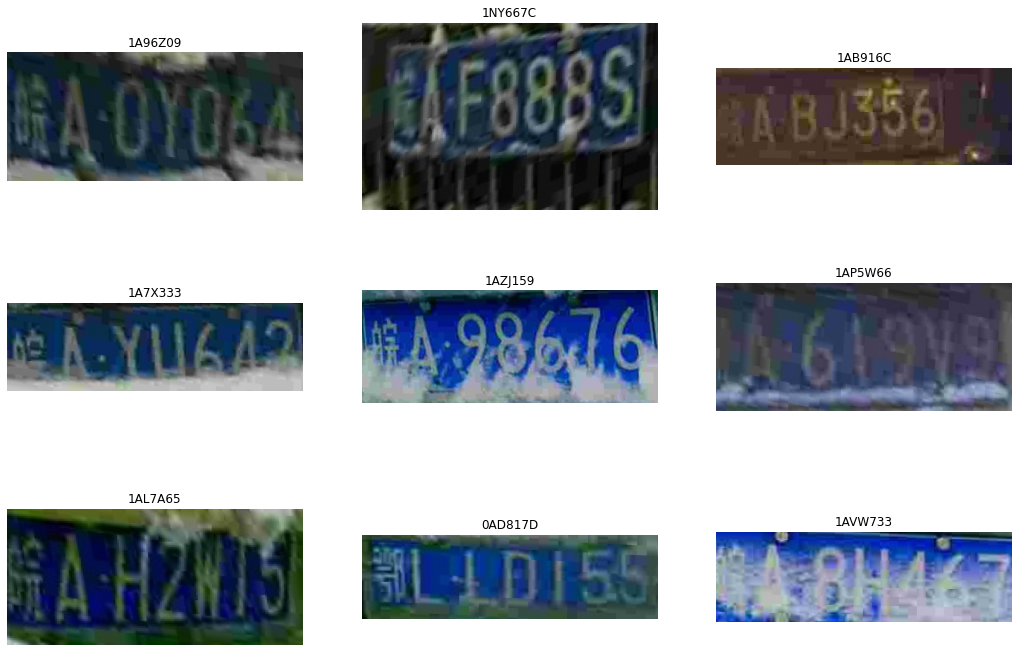

In [80]:
plot_samples(ind[:9], CERs[:9], pred[:9], test_dataset)